In [1]:
from __future__ import division
import os
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# For time stamps
from datetime import datetime

# import models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import keras
import tensorflow as tf

# get a helper function for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
# get a function for measuring test error
from sklearn.metrics import mean_absolute_error
# get a standard scaler for normalization
from sklearn.preprocessing import StandardScaler

# import keras again for building neural network models
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
isdownload = True

stocknames = ['0002.HK', '0003.HK', '0012.HK', '0017.HK', '1398.HK', '3988.HK', '0669.HK', '2382.HK', '1299.HK', '0388.HK']
startdate = '2011-01-01'
enddate = '2017-12-31'
window = 20
target = 5
valid_len = 250

if isdownload == False:
    for stock in stocknames:
        df = yf.download(stock, startdate, enddate)
        df.to_csv('data/{}.csv'.format(stock))

In [3]:
def appending(cols=[], startdate='', enddate=''):
    global df
    dates = pd.date_range(start=startdate, end=enddate)
    df = pd.DataFrame(index=dates)
    for stock in stocknames:
        df_symbols = pd.read_csv(os.path.join('data/{}.csv'.format(stock)),
                                index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_symbols = df_symbols.rename(columns={'Adj Close': stock})
        df = df.join(df_symbols)
        df = df.loc[dates]
    df = df.dropna()
    return df

dfs =appending(['Date', 'Adj Close'], startdate, enddate)
dfs.index.names = ['Date']
dfs.to_csv("data/overall.csv")

In [4]:
df = pd.DataFrame(dfs[stocknames[8]]).copy()
df.rename(columns={df.columns[0]: 'Close'}, inplace=True)
df['temp'] = df['Close'].pct_change()*100
for n in range(1, 15+1):
    df[f'{n}_day_chg%'] = df.temp.shift(n)
df['trend'] =(df['Close'].pct_change(-5)<0).astype(int)
df.drop('temp', axis=1, inplace=True)
df.dropna(inplace=True)
df.head(5)

,Close,1_day_chg%,2_day_chg%,3_day_chg%,4_day_chg%,5_day_chg%,6_day_chg%,7_day_chg%,8_day_chg%,9_day_chg%,10_day_chg%,11_day_chg%,12_day_chg%,13_day_chg%,14_day_chg%,15_day_chg%,trend
Date,,,,,,,,,,,,,,,,,
2011-01-25,18.207283,1.388888,-0.689639,0.000000,2.836879,-0.235847,-0.934572,-1.609204,1.398558,-1.152043,-0.229873,-2.466389,0.000000,-0.668146,-0.443476,1.348335,0
2011-01-26,18.123764,-0.456628,1.388888,-0.689639,0.000000,2.836879,-0.235847,-0.934572,-1.609204,1.398558,-1.152043,-0.229873,-2.466389,0.000000,-0.668146,-0.443476,0
2011-01-27,18.290804,-0.458712,-0.456628,1.388888,-0.689639,0.000000,2.836879,-0.235847,-0.934572,-1.609204,1.398558,-1.152043,-0.229873,-2.466389,0.000000,-0.668146,1
2011-01-28,18.082005,0.921662,-0.458712,-0.456628,1.388888,-0.689639,0.000000,2.836879,-0.235847,-0.934572,-1.609204,1.398558,-1.152043,-0.229873,-2.466389,0.000000,1
2011-01-31,17.914970,-1.141554,0.921662,-0.458712,-0.456628,1.388888,-0.689639,0.000000,2.836879,-0.235847,-0.934572,-1.609204,1.398558,-1.152043,-0.229873,-2.466389,1


In [5]:
def preprocess_data(df):  
    # Initialize MinMaxScaler for X and Y
    Xscaler, Yscaler = MinMaxScaler(feature_range = (0, 1)),MinMaxScaler(feature_range = (0, 1))

    # Select X and Y columns from the DataFrame
    X = df[df.columns[1:-1]]
    Y = df[df.columns[-1:]]

    # Scale X and Y using MinMaxScaler
    X = Xscaler.fit_transform(X)

    # Split the data into x_train and y_train
    x_train, y_train = np.array(X[:-valid_len]), np.array(Y[:-valid_len])

    # Split the data into x_train and y_train
    x_test, y_test = np.array(X[-valid_len:]), np.array(Y[-valid_len:])

    # Reshape x_train and  to match the expected input shape for the model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return Xscaler, X, Y, x_train, y_train, x_test, y_test

In [6]:
# Preprocess the data
Xscaler, X, Y, x_train, y_train , x_test, y_test= preprocess_data(df)
# Print the shapes and types of x_train and y_train
print("x_train:", x_train.shape, ", y_train:", y_train.shape)
print("x_train:", type(x_train), ", y_train:", type(y_train))

x_train: (1459, 15, 1) , y_train: (1459, 1)
x_train: <class 'numpy.ndarray'> , y_train: <class 'numpy.ndarray'>


Epoch 1/25
30/30 - 5s - loss: 1.9797 - accuracy: 0.4542 - val_loss: 1.7392 - val_accuracy: 0.5205 - 5s/epoch - 150ms/step
Epoch 2/25
30/30 - 0s - loss: 1.5484 - accuracy: 0.4542 - val_loss: 1.6006 - val_accuracy: 0.5205 - 289ms/epoch - 10ms/step
Epoch 3/25
30/30 - 0s - loss: 1.2624 - accuracy: 0.4542 - val_loss: 1.4987 - val_accuracy: 0.5205 - 288ms/epoch - 10ms/step
Epoch 4/25
30/30 - 0s - loss: 1.0047 - accuracy: 0.4542 - val_loss: 1.4088 - val_accuracy: 0.5205 - 289ms/epoch - 10ms/step
Epoch 5/25
30/30 - 0s - loss: 0.8367 - accuracy: 0.4542 - val_loss: 1.3138 - val_accuracy: 0.5205 - 291ms/epoch - 10ms/step
Epoch 6/25
30/30 - 0s - loss: 0.7524 - accuracy: 0.4542 - val_loss: 1.2133 - val_accuracy: 0.5205 - 287ms/epoch - 10ms/step
Epoch 7/25
30/30 - 0s - loss: 0.7151 - accuracy: 0.4567 - val_loss: 1.1101 - val_accuracy: 0.5205 - 289ms/epoch - 10ms/step
Epoch 8/25
30/30 - 0s - loss: 0.7009 - accuracy: 0.4919 - val_loss: 1.0089 - val_accuracy: 0.5205 - 290ms/epoch - 10ms/step
Epoch 9/25

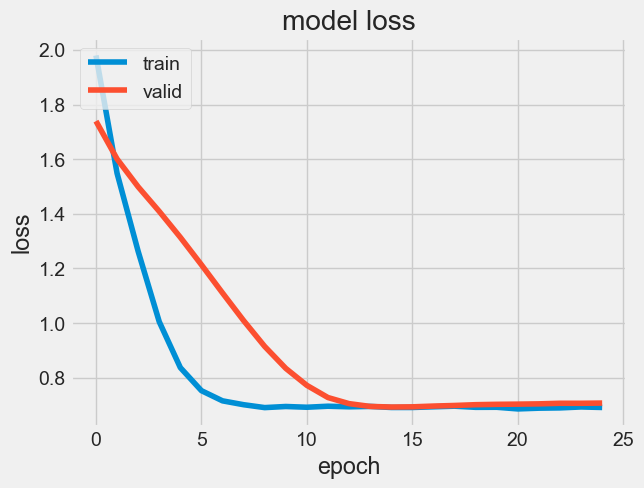

In [12]:
dp = 0.2
model = Sequential()
model.add(LSTM(units=32, return_sequences=True,
          input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(dp))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(dp))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(dp))
model.add(LSTM(units=32))
model.add(Dropout(dp))
model.add(Dense(units=8, activation="softmax"))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])

train_history = model.fit(x_train, y_train,
                          batch_size=40,
                          epochs=25, verbose=2,
                          validation_split=0.2)

# polt
loss = train_history.history["loss"]
var_loss = train_history.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(var_loss, label="val_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("model loss")
plt.legend(["train", "valid"], loc="upper left")

In [13]:
predictions = model.predict(x_test)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 [==============================] - 1s 4ms/step


0.48819398047960155

In [14]:
predictions

array([[0.56491446],
       [0.5654948 ],
       [0.56787175],
       [0.5661337 ],
       [0.5661198 ],
       [0.5667788 ],
       [0.562276  ],
       [0.560171  ],
       [0.55673975],
       [0.5508757 ],
       [0.5500913 ],
       [0.55342174],
       [0.5547167 ],
       [0.5570032 ],
       [0.5574561 ],
       [0.5567604 ],
       [0.5585732 ],
       [0.5608716 ],
       [0.5613653 ],
       [0.56299996],
       [0.56205106],
       [0.5610405 ],
       [0.56112206],
       [0.563502  ],
       [0.56687534],
       [0.56779546],
       [0.5665317 ],
       [0.5669798 ],
       [0.5655614 ],
       [0.56750673],
       [0.56704706],
       [0.56527305],
       [0.5660504 ],
       [0.5645814 ],
       [0.56498694],
       [0.55673337],
       [0.55658555],
       [0.55753136],
       [0.55863947],
       [0.5593869 ],
       [0.56196284],
       [0.5564799 ],
       [0.5631986 ],
       [0.563404  ],
       [0.5644372 ],
       [0.5662158 ],
       [0.56629735],
       [0.565

In [16]:
valid = df[-valid_len:]
valid.loc[:, "predict"] = predictions
threshold = valid["predict"].median()  # Assuming "middle" refers to the median value
valid["label"] = (valid["predict"] > threshold).astype(int)

C:\Users\bruce\AppData\Local\Temp\ipykernel_25296\3609566174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, "predict"] = predictions
C:\Users\bruce\AppData\Local\Temp\ipykernel_25296\3609566174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["label"] = (valid["predict"] > threshold).astype(int)


In [18]:

# Assuming "trend" and "label" columns exist in the "valid" DataFrame
tp = ((valid['trend'] == 1) & (valid['label'] == 1)).sum()
tn = ((valid['trend'] == 0) & (valid['label'] == 0)).sum()
fp = ((valid['trend'] == 0) & (valid['label'] == 1)).sum()
fn = ((valid['trend'] == 1) & (valid['label'] == 0)).sum()

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)

True Positives (TP): 89
True Negatives (TN): 58
False Positives (FP): 36
False Negatives (FN): 67


In [19]:
valid['cumulative'] = valid['label'].rolling(5).sum()
stackTrader = valid[['Close','trend' ,'cumulative']].resample('w').last()

C:\Users\bruce\AppData\Local\Temp\ipykernel_25296\1865304639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['cumulative'] = valid['label'].rolling(5).sum()


<Axes: xlabel='Date'>

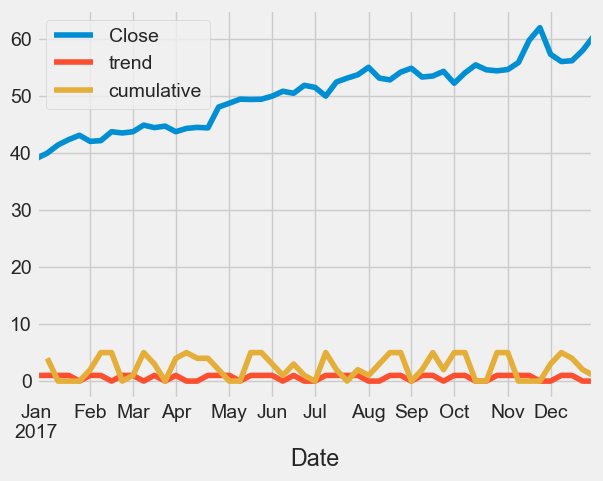

In [21]:
stackTrader.plot()

In [11]:
import pandas as pd

# Reset variables for each iteration
stocks_on_hand = 0
portfolio_value = 0

buy =mean-std
sell = max_value*0.8

# Create a new column to store the action
stackTrader['action'] = ''

for index, row in stackTrader.iterrows():
    price = row['close']
    if row['cumulativeChg'] >= buy and stocks_on_hand == 0:
        stocks_on_hand += 1
        portfolio_value -= price
        stackTrader.at[index, 'action'] = 'buy'
     
    elif not row['cumulativeChg'] < sell and stocks_on_hand == 1:
        stocks_on_hand -= 1
        portfolio_value += price
        stackTrader.at[index, 'action'] = 'sell'
    else:
        stackTrader.at[index, 'action'] = 'hold'
    stackTrader.at[index, 'portfolio'] = portfolio_value + price * stocks_on_hand

# Calculate profit for the current buy and sell levels
profit = portfolio_value + price * stocks_on_hand

print("Maximum Profit:", profit)

NameError: name 'mean' is not defined